# Mapping cells across space and time

This tutorial presents the standard pipeline for mapping cells across time-points utilising spatial information using the moscot solver :class:`moscot.solvers.spatio_temporal.SpatioTemporalProblem`.

We exemplify this using a subsample of spatiotemporal transcriptomics atlas of mouse organogenesis
using DNA nanoball-patterned arrays generated by :cite:`chen:22`.

In [2]:
import numpy as np
import squidpy as sq
import matplotlib.pyplot as plt

from moscot.problems.spatio_temporal import SpatioTemporalProblem
from moscot.datasets import mosta
import moscot.plotting as mpl

## Load the data

The anndata object includes three time-points with embryo sections E9.5 E2S1, E10.5 E2S1, E11.5 E1S2.
The :attr:`anndata.AnnData.X` entry is based on reprocessing of the counts data consisting of :meth:`scanpy.pp.normalize_total` and :meth:`scanpy.pp.log1p`

In [3]:
adata = mosta()

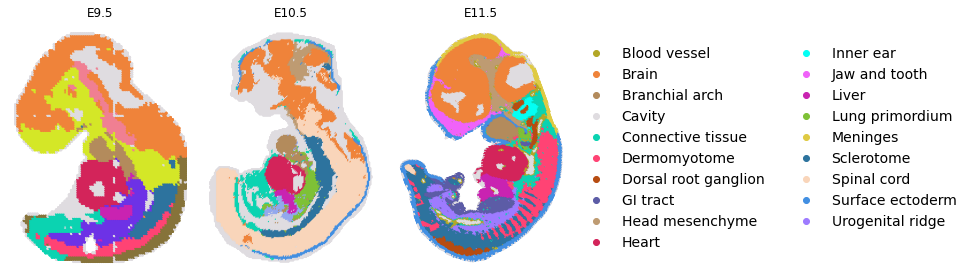

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(14,4))
for i, tp in enumerate(adata.obs["timepoint"].cat.categories):
    sq.pl.spatial_scatter(
        adata[adata.obs["timepoint"].isin([tp])].copy(), 
        color=["annotation"],
        title = [f"{tp}"],
        frameon=False,
        shape=None,
        library_id="hires",
        legend_fontsize = 14,
        ax=axs[i])
    if i < 2:
        axs[i].legend().remove()
    
plt.tight_layout()
plt.show()

## Set `SpatioTemporalProblem`

To set a problem we need to specify the following parameters:

 - `time_key` - Time point key in :attr:`anndata.AnnData.obs`.
 - `spatial_key` - Key in :attr:`anndata.AnnData.obsm` where spatial coordinates are stored.
 - `joint_attr` - The key for the joint space fot the mapping.
     * If `None`, a value is computed based on `callback` using :attr:`anndata.AnnData.X`.
           If callback is not specified PCA is computed.
     * If `str`, it must refer to a key in :attr:`anndata.AnnData.obsm`.
     * If `dict`, the dictionary stores `attr` (attribute of :class:`anndata.AnnData`) and `key`
       (key of :class:`anndata.AnnData` ``[{attr}']``)
 - `callback` - Custom callback applied to each distribution as preprocessing step.

 ** For the purpose of iilustration we specifically specify the callback but this is not necessary.

In [5]:
stp = SpatioTemporalProblem(adata=adata).prepare(
    time_key="time",
    spatial_key="spatial",
    joint_attr=None,
    callback="local-pca",
)


INFO     Computing pca with `n_comps=30` using `adata.X`                                                           
INFO     Computing pca with `n_comps=30` using `adata.X`                                                           


## Solve the problem

To solve the problem we call :class:`moscot.solvers.spatio_temporal.SpatioTemporalProblem.solve()` and pass:

- `alpha` - Interpolation parameter between quadratic term (spatial coordinates) and linear term (PCA space).
- `epsilon` - Entropic regularisation parameter.
- `rank` – the rank constraint on the coupling to minimize the linear OT problem.
- `gamma` – the (inverse of) gradient stepsize used by mirror descent.

Here we utilize a `Low Rank` approach suggested by suggested by Meyer et al. :cite`scetbon:2021_a` :cite`scetbon:2021_b` which is beneficial when considering large datasets. 


In [6]:
stp =  stp.solve(alpha=0.9, epsilon=1e-3, rank=100, gamma=100)

INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5870, 18292)].                                 
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(18292, 29972)].                                


## Visualize the results

### cell-transition map
We start by assessing the cell-transition map between the cell tissue groups in the data.

Given a mapping $\pi_{s, t}$, from source ($s$) cells to target ($t$) cells, the **cell-transition map**, 
$C_{s^{(g)}, t^{(g)}}$ is given by aggregating over source groups ($s^{(g)}$) and target groups ($t^{(g)}$). 

The $i,j$ entry  depicts the mass transferred from the $i$th group in the source population ($s^{(g)}_{i}$) to the $j$th group in the target population ($t^{(g)}_{j}$). Formally this is given by:
$$ C_{s^{(g)}, t^{(g)}}\left(i, j\right) = \sum_{x\in s^{(g)}_{i}} \sum_{y\in t^{(g)}_{j}} \pi_{s, t}\left(x, y\right) $$

We use :class:`moscot.solvers.spatio_temporal.SpatioTemporalProblem.cell_transition()` to compute the cell-transition map according to the groups defined in `adata.obs["annotation"]` denoting the tissue assignment of the cells inferred by :cite:`chen:22`. Then we use :class:`moscot.plotting.cell_transition()` to visualize the results


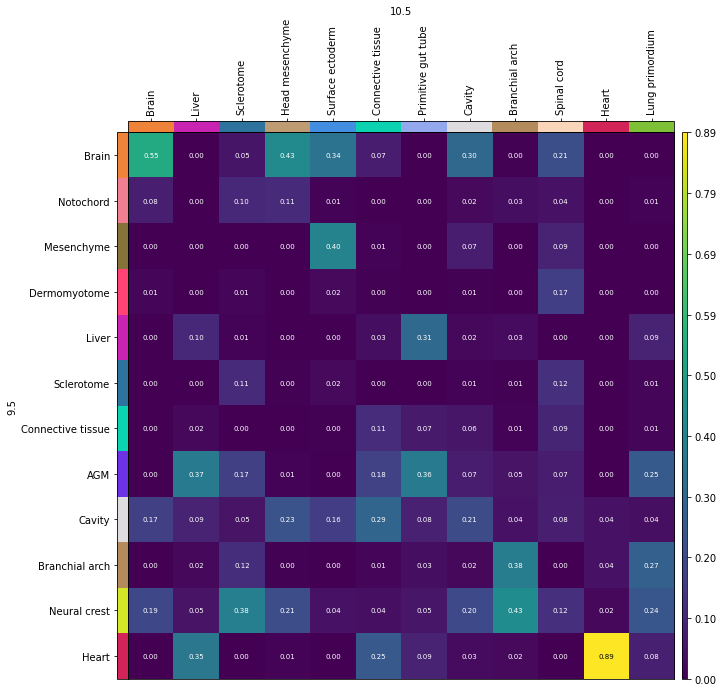

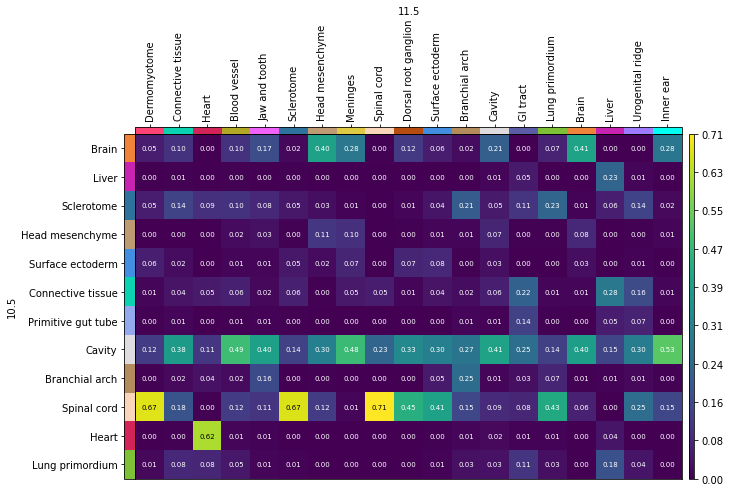

In [7]:
# TODO: modify after issue # passing `fig` is resolved
# fig, axs = plt.subplots(1, 2)

for key, prob in stp.problems.items():
    start, end = key
    stp.cell_transition(
        source=start,
        target=end,
        source_groups="annotation",
        target_groups="annotation",
    )
    
    mpl.cell_transition(stp, figsize=(8,8))

As expected we see that cell-types repeating across time points are mainly mapped to themselves.

### Spatial `push` mapping

Next, we can visualize the **predicted spatial destination of the cells**, again considering the tissue labels. 

Using the _push_ operation we can compute the **descendants** of a set of cells. Formally, given a one-hot encoding of single group of cells in the source distribution ($\vec{p}_{s^{(g)}_{i}}$) the _push_ output vector ($p_{t^{(g)}_{i}}$) is defined over the target distribution and given by:
$$ p_{t^{(g)}_{i}} = \vec{p}_{s^{(g)}_{i}}^{T} \cdot \pi_{s, t} $$

Again, we consider the set of cells using `adata.obs["annotation"]` labels, subsetting according to assigned tissue (`col`), e.g. `Heart` cells. <br>
Given a set of cells at an early time point we use the :class:`moscot.backends.ott._output.OTTOutput.push()` function to find the _push_ output vector towards a later time point and save it in `adata.obs[f"{col}_mapping"]`.

In [8]:
for key, prob in stp.problems.items():
    start, end = key
    for col in adata[adata.obs["time"].isin([start])].obs["annotation"].cat.categories:
        adata.obs.loc[adata.obs["time"].isin([end]) ,f"{col}_mapping"] = stp.push(start=start,
         end=end,
         data="annotation",
         subset=col,
         return_data=True,
        )[end]

We focus on the `Heart` tissue. <br>
In the first row we plot the spatial locations of the `Heart` cells in each time point. <br>
In the second row  we show the _push_ output vector projected onto the the spatial coordinates.

In [9]:
tissue = "Heart"

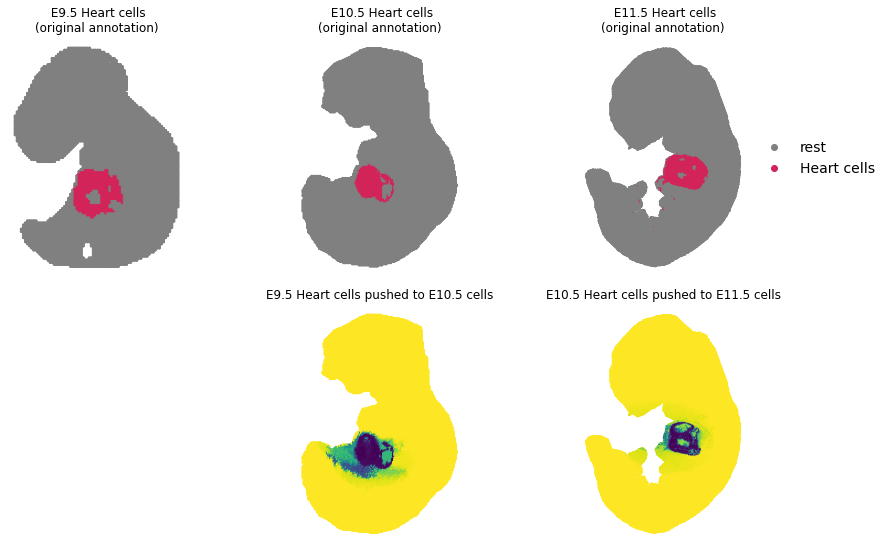

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(14,8))
timepoints = [9.5, 10.5, 11.5]
for i, tp in enumerate(timepoints):
    sq.pl.spatial_scatter(
        adata[adata.obs["time"].isin([tp])].copy(), 
        color=[f"{tissue}_annotation"],
        title = [f" E{tp} {tissue} cells\n(original annotation)"],
        frameon=False,
        shape=None,
        library_id="hires",
        legend_fontsize = 14,
        ax=axs[0, i]
    )
    if i > 0:
        sq.pl.spatial_scatter(
            adata[adata.obs["time"].isin([tp])].copy(), 
            color=[f"{tissue}_mapping"],
            title = [f"E{timepoints[i-1]} {tissue} cells pushed to E{timepoints[i]} cells"], 
            frameon=False,
            shape=None,
            library_id="hires",
            legend_fontsize = 14,
            cmap="viridis_r",
            colorbar=False,
            ax=axs[1, i]
        )
        
    if i < 2:
        axs[0, i].legend().remove()
    
plt.tight_layout()
axs[1, 0].remove()
plt.show()